## 1. Setup and Imports

In [2]:
# Standard library imports
import sys
import asyncio
from pathlib import Path
from typing import Optional, Dict, Any

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Statistical analysis
from scipy.stats import linregress, norm as scipy_norm
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Logging
from loguru import logger

# Configure matplotlib for notebook
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
%matplotlib inline

# Configure logger
logger.remove()
logger.add(
    sys.stdout,
    level="INFO",
    colorize=True,
    format="<green>{time:HH:mm:ss}</green> | <level>{message}</level>",
)

print("All packages imported successfully!")

All packages imported successfully!


## 2. Import EVAonline Modules

In [12]:
# Add scripts directory to Python path
PROJECT_ROOT = Path.cwd()
SCRIPTS_DIR = PROJECT_ROOT / "scripts"
sys.path.insert(0, str(PROJECT_ROOT))
sys.path.insert(0, str(SCRIPTS_DIR))

# Import EVAonline modules
from scripts.config import (
    XAVIER_RESULTS_DIR,
    BRASIL_CITIES,
    get_xavier_eto_path,
)
from scripts.api.services.opentopo.opentopo_sync_adapter import (
    OpenTopoSyncAdapter,
)
from scripts.api.services.geographic_utils import GeographicUtils
from scripts.core.data_processing.data_preprocessing import (
    preprocessing,
)
from scripts.core.data_processing.kalman_ensemble import (
    ClimateKalmanEnsemble,
)
from scripts.core.eto_calculation.eto_services import (
    calculate_eto_timeseries,
)

print("EVAonline modules imported successfully!")

EVAonline modules imported successfully!


## 3. Configure Paths and Parameters

In [13]:
# Data directories
DATA_DIR = PROJECT_ROOT / "data" / "original_data"
NASA_RAW_DIR = DATA_DIR / "nasa_power_raw"
OPENMETEO_RAW_DIR = DATA_DIR / "open_meteo_raw"
OUTPUT_DIR = PROJECT_ROOT / "data" / "6_validation_full_pipeline" / "tutorial_output"

# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load city coordinates
csv_coords = PROJECT_ROOT / "data" / "info_cities.csv"
df_coords = pd.read_csv(csv_coords)
city_coords = {
    row["city"]: (row["lat"], row["lon"], row["alt"])
    for _, row in df_coords.iterrows()
}

print(f"Data directories configured")
print(f"NASA POWER: {NASA_RAW_DIR}")
print(f"Open-Meteo: {OPENMETEO_RAW_DIR}")
print(f"Output: {OUTPUT_DIR}")
print(f"\nLoaded coordinates for {len(city_coords)} cities")

Data directories configured
NASA POWER: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\original_data\nasa_power_raw
Open-Meteo: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\original_data\open_meteo_raw
Output: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\6_validation_full_pipeline\tutorial_output

Loaded coordinates for 17 cities


## 4. Select City for Tutorial

We'll use **Piracicaba, SP** as an example (ESALQ/USP reference station)

In [14]:
# Select city for tutorial
CITY_NAME = "Piracicaba_SP"

# Get coordinates and elevation
lat, lon, elevation = city_coords[CITY_NAME]

print(f"Selected City: {CITY_NAME}")
print(f"Latitude: {lat:.4f}°")
print(f"Longitude: {lon:.4f}°")
print(f"Elevation: {elevation:.1f} m")
print(f"\nPeriod: 1991-01-01 to 2020-12-31 (30 years)")

Selected City: Piracicaba_SP
Latitude: -22.7250°
Longitude: -47.6476°
Elevation: 524.0 m

Period: 1991-01-01 to 2020-12-31 (30 years)


## 5. Load Raw Climate Data

### 5.1 Load NASA POWER Data

In [15]:
def load_raw_data(city_name: str, source: str) -> pd.DataFrame:
    """
    Load local RAW data with intelligent fallback using glob pattern.
    
    Args:
        city_name: City name
        source: 'nasa' or 'openmeteo'
    
    Returns:
        DataFrame with RAW data
    """
    pattern = f"{city_name}_*.csv"
    directory = NASA_RAW_DIR if source == "nasa" else OPENMETEO_RAW_DIR
    
    files = list(directory.glob(pattern))
    if not files:
        logger.error(f"{source.upper()} not found: {city_name}")
        return pd.DataFrame()
    
    df = pd.read_csv(files[0])
    df["date"] = pd.to_datetime(df["date"])
    logger.info(f"{source.upper()}: {len(df)} days → {files[0].name}")
    return df


# Load NASA POWER data
nasa_raw = load_raw_data(CITY_NAME, "nasa")

print(f"\nNASA POWER Data Summary:")
print(f"Shape: {nasa_raw.shape}")
print(f"Columns: {list(nasa_raw.columns)}")
print(f"\nFirst 5 rows:")
nasa_raw.head()

22:33:59 | NASA: 10958 days → Piracicaba_SP_1991-01-01_2020-12-31_NASA_RAW.csv

NASA POWER Data Summary:
Shape: (10958, 8)
Columns: ['date', 'T2M_MAX', 'T2M_MIN', 'T2M', 'RH2M', 'WS2M', 'ALLSKY_SFC_SW_DWN', 'PRECTOTCORR']

First 5 rows:

NASA POWER Data Summary:
Shape: (10958, 8)
Columns: ['date', 'T2M_MAX', 'T2M_MIN', 'T2M', 'RH2M', 'WS2M', 'ALLSKY_SFC_SW_DWN', 'PRECTOTCORR']

First 5 rows:


,date,T2M_MAX,T2M_MIN,T2M,RH2M,WS2M,ALLSKY_SFC_SW_DWN,PRECTOTCORR
0,1991-01-01,30.04,17.52,23.38,60.93,1.99,24.77,0.56
1,1991-01-02,32.42,16.45,24.60,64.43,1.93,23.66,1.01
2,1991-01-03,29.39,19.95,23.76,79.21,2.17,14.69,12.70
3,1991-01-04,26.56,18.70,22.48,80.44,1.78,12.90,13.57
4,1991-01-05,25.87,17.65,21.15,76.98,3.30,24.51,0.25


### 5.2 Load Open-Meteo Data

In [16]:
# Load Open-Meteo data
om_raw = load_raw_data(CITY_NAME, "openmeteo")

print(f"\nOpen-Meteo Data Summary:")
print(f"Shape: {om_raw.shape}")
print(f"Columns: {list(om_raw.columns)}")
print(f"\nFirst 5 rows:")
om_raw.head()

22:34:09 | OPENMETEO: 10958 days → Piracicaba_SP_1991-01-01_2020-12-31_OpenMeteo_RAW.csv

Open-Meteo Data Summary:
Shape: (10958, 8)
Columns: ['date', 'T2M_MAX', 'T2M_MIN', 'T2M', 'RH2M', 'WS10M', 'ALLSKY_SFC_SW_DWN', 'PRECTOTCORR']

First 5 rows:

Open-Meteo Data Summary:
Shape: (10958, 8)
Columns: ['date', 'T2M_MAX', 'T2M_MIN', 'T2M', 'RH2M', 'WS10M', 'ALLSKY_SFC_SW_DWN', 'PRECTOTCORR']

First 5 rows:


,date,T2M_MAX,T2M_MIN,T2M,RH2M,WS10M,ALLSKY_SFC_SW_DWN,PRECTOTCORR
0,1991-01-01,28.4,17.7,23.1,61,5.28,25.37,0.0
1,1991-01-02,29.6,17.6,24.1,66,4.95,26.47,0.2
2,1991-01-03,30.8,19.9,24.0,77,4.63,22.27,9.1
3,1991-01-04,23.4,20.3,21.4,93,4.05,4.72,24.8
4,1991-01-05,28.1,18.2,22.6,74,7.92,22.62,0.0


## 6. Elevation Retrieval (OpenTopoData API)

Elevation is critical for FAO-56 calculations:
- Atmospheric pressure correction
- Psychrometric constant calculation
- Extraterrestrial radiation adjustment

In [17]:
async def get_elevation_from_api(lat: float, lon: float, fallback: float) -> float:
    """
    Fetch elevation via OpenTopoData API with fallback.
    
    Args:
        lat: Latitude
        lon: Longitude
        fallback: Fallback elevation from CSV
    
    Returns:
        Elevation in meters (uses fallback if API fails)
    """
    try:
        topo = OpenTopoSyncAdapter()
        elevation_obj = await asyncio.to_thread(
            topo.get_elevation_sync, lat, lon
        )
        if elevation_obj and hasattr(elevation_obj, "elevation"):
            elev = float(elevation_obj.elevation)
            logger.info(f"OpenTopoData elevation: {elev:.1f}m")
            return elev
    except Exception as e:
        logger.warning(f"OpenTopoData failed: {str(e)[:80]}")
        logger.info(f"→ Using CSV elevation as fallback: {fallback:.1f}m")
    return fallback


# Fetch elevation from OpenTopoData API
print(f"Fetching elevation from OpenTopoData API...")
print(f"Coordinates: {lat:.4f}°N, {lon:.4f}°E")
print(f"Fallback (CSV): {elevation:.1f}m")

elevation_final = await get_elevation_from_api(lat, lon, elevation)
print(f"\n🏔️Final elevation: {elevation_final:.1f} m")

Fetching elevation from OpenTopoData API...
Coordinates: -22.7250°N, -47.6476°E
Fallback (CSV): 524.0m
22:34:14 | OpenTopoSyncAdapter initialized | No cache | dataset=srtm30m,aster30m
22:34:15 | OpenTopoClient initialized | default dataset=srtm30m,aster30m
22:34:15 | OpenTopoClient initialized | default dataset=srtm30m,aster30m
22:34:15 | Elevation obtained | (-22.7250, -47.6476) = 534.0m | srtm30m,aster30m
22:34:15 | OpenTopoData elevation: 534.0m

🏔️Final elevation: 534.0 m
22:34:15 | Elevation obtained | (-22.7250, -47.6476) = 534.0m | srtm30m,aster30m
22:34:15 | OpenTopoData elevation: 534.0m

🏔️Final elevation: 534.0 m


## 7. Data Preprocessing (FAO-56)

### 7.1 Wind Speed Conversion (10m → 2m)

**Critical**: Open-Meteo provides wind at 10m height, but FAO-56 requires 2m.  
Use FAO-56 Equation 47:

$$u_2 = u_z \cdot \frac{4.87}{\ln(67.8 \cdot z - 5.42)}$$

In [18]:
# Convert Open-Meteo wind from 10m to 2m (vectorized)
if not om_raw.empty and "WS10M" in om_raw.columns:
    print("Converting wind speed: 10m → 2m (FAO-56 Eq. 47)")
    om_raw["WS2M"] = np.maximum(
        om_raw["WS10M"] * (4.87 / np.log(67.8 * 10 - 5.42)),
        0.5,  # minimum physical limit
    )
    om_raw = om_raw.drop(columns=["WS10M"], errors="ignore")
    print(f"Wind conversion completed: {len(om_raw)} records")
    print(f"Mean wind @ 2m: {om_raw['WS2M'].mean():.2f} m/s")

Converting wind speed: 10m → 2m (FAO-56 Eq. 47)
Wind conversion completed: 10958 records
Mean wind @ 2m: 4.09 m/s


### 7.2 FAO-56 Preprocessing (Quality Control + Derived Variables)

In [19]:
# Detect region based on coordinates (Brazil vs Global limits)
is_brazil = GeographicUtils.is_in_brazil(lat, lon)
region = "brazil" if is_brazil else "global"

print(f"\nRegion Detection:")
print(f"Coordinates: {lat:.4f}°, {lon:.4f}°")
print(f"Region: {'Brazil (Xavier et al. limits)' if is_brazil else 'Global (world limits)'}")

# Preprocess NASA POWER data with region-specific limits
print(f"\nPreprocessing NASA POWER data (region={region})...")
nasa_clean, _ = preprocessing(nasa_raw.set_index("date"), lat, region=region)
nasa_clean = nasa_clean.reset_index()
print(f"NASA POWER: {len(nasa_clean)} days after preprocessing")

# Preprocess Open-Meteo data with region-specific limits
print(f"\nPreprocessing Open-Meteo data (region={region})...")
om_clean, _ = preprocessing(om_raw.set_index("date"), lat, region=region)
om_clean = om_clean.reset_index()
print(f"Open-Meteo: {len(om_clean)} days after preprocessing")

print("\nPreprocessed NASA POWER sample:")
display(nasa_clean.head())

print("\nPreprocessed Open-Meteo sample:")
display(om_clean.head())


Region Detection:
Coordinates: -22.7250°, -47.6476°
Region: Brazil (Xavier et al. limits)

Preprocessing NASA POWER data (region=brazil)...
22:35:58 | Starting preprocessing pipeline (validation mode)
22:35:58 | Validating weather data
22:35:58 | Using Brazil validation limits (Xavier et al.)
22:35:58 | Validating weather data
22:35:58 | Using Brazil validation limits (Xavier et al.)
22:35:58 | Detecting outliers with seasonal IQR method (historical series: 10958 days)
22:35:58 | Detecting outliers with seasonal IQR method (historical series: 10958 days)
22:35:58 | No outliers detected with IQR method.
22:35:58 | Imputing missing weather data
22:35:58 | Preprocessing summary: 0 validation corrections, 0 outlier removals, 0 imputations performed.
NASA POWER: 10958 days after preprocessing

Preprocessing Open-Meteo data (region=brazil)...
22:35:58 | Starting preprocessing pipeline (validation mode)
22:35:58 | Validating weather data
22:35:58 | Using Brazil validation limits (Xavier et a

,date,T2M_MAX,T2M_MIN,T2M,RH2M,WS2M,ALLSKY_SFC_SW_DWN,PRECTOTCORR,day_of_year,Ra,dr,delta,omega_s
0,1991-01-01,30.04,17.52,23.38,60.93,1.99,24.77,0.56,1.0,42.688896,1.032995,-0.401008,1.749316
1,1991-01-02,32.42,16.45,24.60,64.43,1.93,23.66,1.01,2.0,42.673233,1.032980,-0.399564,1.748591
2,1991-01-03,29.39,19.95,23.76,79.21,2.17,14.69,12.70,3.0,42.655852,1.032956,-0.398001,1.747808
3,1991-01-04,26.56,18.70,22.48,80.44,1.78,12.90,13.57,4.0,42.636740,1.032922,-0.396320,1.746967
4,1991-01-05,25.87,17.65,21.15,76.98,3.30,24.51,0.25,5.0,42.615881,1.032878,-0.394522,1.746069



Preprocessed Open-Meteo sample:


,date,T2M_MAX,T2M_MIN,T2M,RH2M,ALLSKY_SFC_SW_DWN,PRECTOTCORR,WS2M,day_of_year,Ra,dr,delta,omega_s
0,1991-01-01,28.4,17.7,23.1,61,25.37,0.0,3.949182,1.0,42.688896,1.032995,-0.401008,1.749316
1,1991-01-02,29.6,17.6,24.1,66,26.47,0.2,3.702358,2.0,42.673233,1.032980,-0.399564,1.748591
2,1991-01-03,30.8,19.9,24.0,77,22.27,9.1,3.463013,3.0,42.655852,1.032956,-0.398001,1.747808
3,1991-01-04,23.4,20.3,21.4,93,4.72,24.8,3.029202,4.0,42.636740,1.032922,-0.396320,1.746967
4,1991-01-05,28.1,18.2,22.6,74,22.62,0.0,5.923773,5.0,42.615881,1.032878,-0.394522,1.746069


## 8. Kalman Fusion (Multi-Source Integration)

### 8.1 Initialize Kalman Ensemble

The Kalman filter adaptively combines NASA POWER and Open-Meteo data:
- **Process noise**: Seasonal variability from Xavier climatology
- **Measurement noise**: R_NASA=0.3, R_OpenMeteo=0.4
- **Bias correction**: Anchored to Xavier BR-DWGD

In [20]:
# Initialize Kalman ensemble
print("\nInitializing Kalman ensemble...")
kalman = ClimateKalmanEnsemble()
print("Kalman filter initialized")


Initializing Kalman ensemble...
Kalman filter initialized


### 8.2 Vectorized Kalman Fusion

In [21]:
# Perform Kalman fusion
print("\nPerforming vectorized Kalman fusion...")
try:
    fused_df = kalman.fuse_vectorized(
        nasa_df=nasa_clean,
        om_df=om_clean,
        lat=lat,
        lon=lon
    )
    print(f"Fusion completed: {len(fused_df)} days")
except Exception as e:
    print(f"Fusion failed: {e}")
    print("Using NASA POWER only")
    fused_df = nasa_clean.copy()

print("\nFused data sample:")
display(fused_df.head())

# Basic statistics
print("\nFused Data Statistics:")
display(fused_df.describe())


Performing vectorized Kalman fusion...
22:41:18 | Reference: Piracicaba_SP (0.0 km)
Fusion completed: 10958 days

Fused data sample:
Fusion completed: 10958 days

Fused data sample:


,date,T2M_MAX,T2M_MIN,T2M,RH2M,WS2M,ALLSKY_SFC_SW_DWN,PRECTOTCORR
0,1991-01-01,29.3512,17.6064,23.268,60.9755,3.557345,24.8180,0.725
1,1991-01-02,31.2356,17.0020,24.400,65.4505,3.347886,23.8848,0.607
2,1991-01-03,29.9822,19.9260,23.856,77.7735,3.204411,15.2964,10.821
3,1991-01-04,25.2328,19.4680,22.048,88.6040,2.779361,12.2456,19.120
4,1991-01-05,26.8066,17.9140,21.730,75.0430,5.399018,24.3588,0.207



Fused Data Statistics:


,date,T2M_MAX,T2M_MIN,T2M,RH2M,WS2M,ALLSKY_SFC_SW_DWN,PRECTOTCORR
count,10958,10958.000000,10958.000000,10958.000000,10958.000000,10958.000000,10958.000000,10958.000000
mean,2005-12-31 12:00:00,27.651455,16.576063,21.580410,73.842715,3.676865,18.411091,3.546058
min,1991-01-01 00:00:00,13.113800,1.991600,7.688000,29.486500,1.602148,1.528800,0.000000
25%,1998-07-02 06:00:00,25.627250,13.986400,19.418000,68.030375,2.864919,14.815000,0.011000
50%,2005-12-31 12:00:00,27.810400,17.071400,22.085000,75.614500,3.461370,18.326000,0.491500
75%,2013-07-01 18:00:00,29.748850,19.534500,23.877500,81.541375,4.279546,22.530200,4.734000
max,2020-12-31 00:00:00,41.387400,25.489600,32.522000,94.750500,8.739314,32.405600,58.110000
std,NaN,3.417563,3.532475,3.182498,10.686110,1.101390,5.755995,6.041248


## 9. ETo Calculation (FAO-56 Penman-Monteith)

### 9.1 Calculate Reference Evapotranspiration

FAO-56 Penman-Monteith equation:

$$
\text{ET}_0 = \frac{0.408 \cdot \Delta \cdot (R_n - G) + \gamma \cdot \frac{900}{T + 273} \cdot u_2 \cdot (e_s - e_a)}{\Delta + \gamma \cdot (1 + 0.34 \cdot u_2)}
$$

Where:
- $\Delta$ = slope of saturation vapor pressure curve
- $R_n$ = net radiation
- $G$ = soil heat flux
- $\gamma$ = psychrometric constant
- $u_2$ = wind speed at 2m height
- $e_s$ = saturation vapor pressure
- $e_a$ = actual vapor pressure

In [22]:
# Calculate ETo with final Kalman correction
print("\nCalculating ETo (FAO-56 Penman-Monteith + Kalman correction)...")
df_final = calculate_eto_timeseries(
    df=fused_df,
    latitude=lat,
    longitude=lon,
    elevation_m=elevation_final,
    kalman_ensemble=kalman,
)

print(f"ETo calculation completed: {len(df_final)} days")
print(f"\nETo Statistics:")
print(f"Mean ETo: {df_final['eto_final'].mean():.2f} mm/day")
print(f"Min ETo: {df_final['eto_final'].min():.2f} mm/day")
print(f"Max ETo: {df_final['eto_final'].max():.2f} mm/day")
print(f"Std ETo: {df_final['eto_final'].std():.2f} mm/day")

print("\nFinal data sample:")
display(df_final[["date", "T2M", "RH2M", "WS2M", "ALLSKY_SFC_SW_DWN", "eto_final"]].head())


Calculating ETo (FAO-56 Penman-Monteith + Kalman correction)...
22:46:28 | Final Kalman applied (bias correction + continuous filter)!
ETo calculation completed: 10958 days

ETo Statistics:
Mean ETo: 3.55 mm/day
Min ETo: 1.11 mm/day
Max ETo: 6.98 mm/day
Std ETo: 1.15 mm/day

Final data sample:
22:46:28 | Final Kalman applied (bias correction + continuous filter)!
ETo calculation completed: 10958 days

ETo Statistics:
Mean ETo: 3.55 mm/day
Min ETo: 1.11 mm/day
Max ETo: 6.98 mm/day
Std ETo: 1.15 mm/day

Final data sample:


,date,T2M,RH2M,WS2M,ALLSKY_SFC_SW_DWN,eto_final
0,1991-01-01,23.268,60.9755,3.557345,24.8180,5.284
1,1991-01-02,24.400,65.4505,3.347886,23.8848,5.460
2,1991-01-03,23.856,77.7735,3.204411,15.2964,4.362
3,1991-01-04,22.048,88.6040,2.779361,12.2456,3.075
4,1991-01-05,21.730,75.0430,5.399018,24.3588,4.052


## 10. Validation Against Xavier BR-DWGD

### 10.1 Load Xavier Reference Data

In [23]:
# Load Xavier reference data
print(f"\nLoading Xavier reference data for {CITY_NAME}...")
xavier_file = get_xavier_eto_path(CITY_NAME)

if not xavier_file.exists():
    print(f"Xavier file not found: {xavier_file}")
else:
    df_xavier = pd.read_csv(xavier_file)
    df_xavier["date"] = pd.to_datetime(df_xavier["date"])
    print(f"Xavier data loaded: {len(df_xavier)} days")
    print(f"\nXavier data sample:")
    display(df_xavier.head())


Loading Xavier reference data for Piracicaba_SP...
Xavier data loaded: 10958 days

Xavier data sample:


,date,eto_xavier
0,1991-01-01,5.271654
1,1991-01-02,5.271654
2,1991-01-03,3.377953
3,1991-01-04,2.712598
4,1991-01-05,4.452756


### 10.2 Merge and Calculate Metrics

In [24]:
# Merge EVAonline and Xavier data
print("\nMerging EVAonline and Xavier data...")
df_compare = pd.merge(
    df_final[["date", "eto_final"]],
    df_xavier[["date", "eto_xavier"]],
    on="date",
    how="inner"
).dropna(subset=["eto_final", "eto_xavier"])

print(f"Merged data: {len(df_compare)} days")

# Extract arrays
calc = np.array(df_compare["eto_final"].values, dtype=float)
ref = np.array(df_compare["eto_xavier"].values, dtype=float)

# Calculate metrics
print("\nCalculating validation metrics...")

# Basic metrics
mae = float(mean_absolute_error(ref, calc))
rmse = float(np.sqrt(mean_squared_error(ref, calc)))
bias = float(np.mean(calc - ref))
pbias = float(100 * np.sum(calc - ref) / np.sum(ref))

# Linear regression
lr = linregress(ref, calc)
slope_val = float(lr.slope)
intercept_val = float(lr.intercept)
r_val = float(lr.rvalue)
p_value = float(lr.pvalue)
r2 = float(r_val**2)

# NSE (Nash-Sutcliffe Efficiency)
nse = float(1 - np.sum((calc - ref)**2) / np.sum((ref - ref.mean())**2))

# KGE (Kling-Gupta Efficiency)
r = np.corrcoef(ref, calc)[0, 1]
alpha = np.std(calc) / np.std(ref)
beta = np.mean(calc) / np.mean(ref)
kge = float(1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2))

# Print results
print("\n" + "="*60)
print(f"VALIDATION RESULTS: {CITY_NAME}")
print("="*60)
print(f"\nCorrelation Metrics:")
print(f"R² = {r2:.4f}")
print(f"p-value = {p_value:.6f}")
print(f"Slope = {slope_val:.4f}")
print(f"Intercept = {intercept_val:.4f}")

print(f"\nPerformance Metrics:")
print(f"KGE = {kge:.4f}")
print(f"NSE = {nse:.4f}")
print(f"MAE = {mae:.4f} mm/day")
print(f"RMSE = {rmse:.4f} mm/day")
print(f"\nBias Metrics:")
print(f"Bias = {bias:+.4f} mm/day")
print(f"PBIAS = {pbias:+.2f}%")

print(f"\nSample Size:")
print(f"n = {len(df_compare):,} days")
print("="*60)


Merging EVAonline and Xavier data...
Merged data: 10958 days

Calculating validation metrics...

VALIDATION RESULTS: Piracicaba_SP

Correlation Metrics:
R² = 0.7436
p-value = 0.000000
Slope = 0.8215
Intercept = 0.6664

Performance Metrics:
KGE = 0.8539
NSE = 0.7343
MAE = 0.4567 mm/day
RMSE = 0.6226 mm/day

Bias Metrics:
Bias = +0.0406 mm/day
PBIAS = +1.16%

Sample Size:
n = 10,958 days


## 11. Visualization

### 11.1 Scatter Plot (Observed vs Predicted)

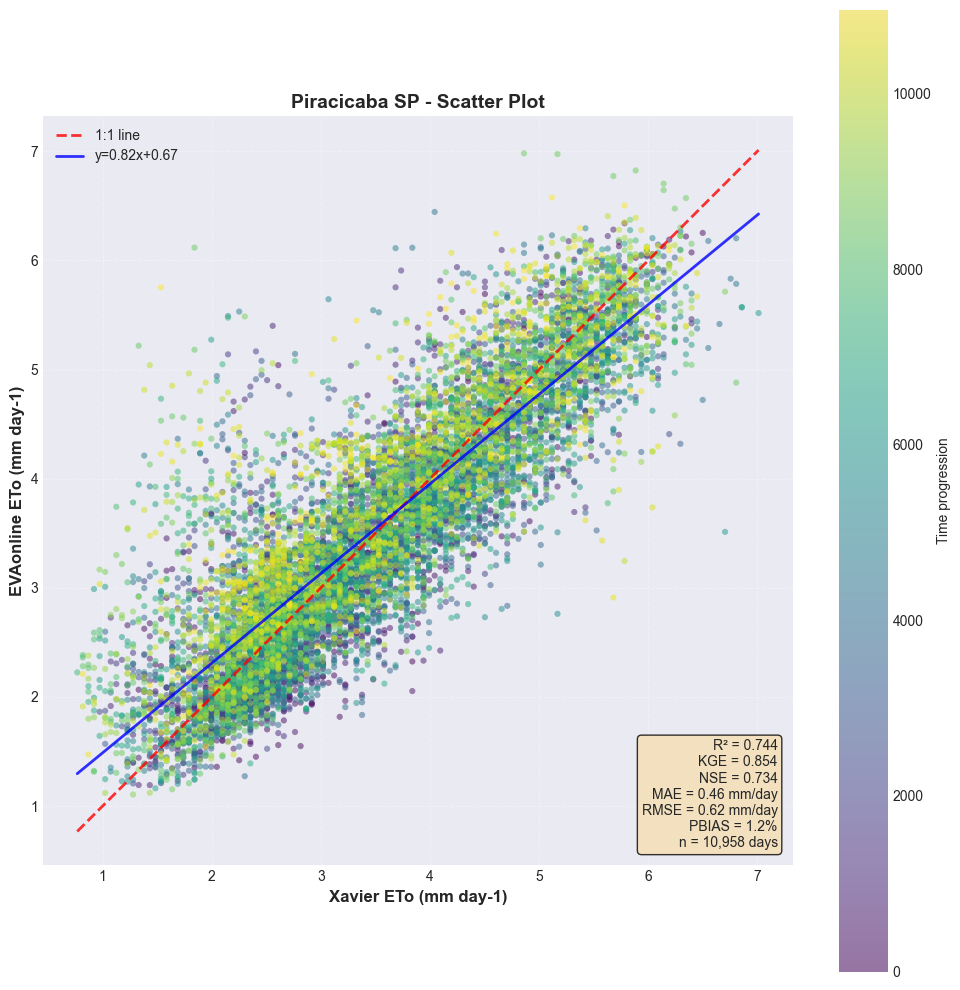


Scatter plot saved: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\6_validation_full_pipeline\tutorial_output\Piracicaba_SP_scatter.png


In [28]:
# Scatter plot
fig, ax = plt.subplots(figsize=(10, 10))

# Scatter with colormap by time
scatter = ax.scatter(
    ref, calc,
    c=np.arange(len(ref)),
    cmap="viridis",
    alpha=0.5,
    s=20,
    edgecolors='none'
)

# 1:1 line
min_val = min(ref.min(), calc.min())
max_val = max(ref.max(), calc.max())
ax.plot(
    [min_val, max_val],
    [min_val, max_val],
    'r--',
    lw=2,
    label='1:1 line',
    alpha=0.8
)

# Regression line
ax.plot(
    [min_val, max_val],
    [slope_val * min_val + intercept_val, slope_val * max_val + intercept_val],
    'b-',
    lw=2,
    label=f'y={slope_val:.2f}x+{intercept_val:.2f}',
    alpha=0.8
)

# Labels and title
ax.set_xlabel('Xavier ETo (mm day-1)', fontsize=12, fontweight='bold')
ax.set_ylabel('EVAonline ETo (mm day-1)', fontsize=12, fontweight='bold')
ax.set_title(f'{CITY_NAME.replace("_", " ")} - Scatter Plot', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_aspect('equal', adjustable='box')

# Add metrics text box
textstr = '\n'.join([
    f'R² = {r2:.3f}',
    f'KGE = {kge:.3f}',
    f'NSE = {nse:.3f}',
    f'MAE = {mae:.2f} mm/day',
    f'RMSE = {rmse:.2f} mm/day',
    f'PBIAS = {pbias:.1f}%',
    f'n = {len(ref):,} days'
])
props = {'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.8}
ax.text(
    0.98, 0.02, textstr,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment='bottom',
    horizontalalignment='right',
    bbox=props
)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Time progression', fontsize=10)

plt.tight_layout()
plt.show()

# Save plot
fig.savefig(OUTPUT_DIR / f"{CITY_NAME}_scatter.png", dpi=300, bbox_inches='tight')
print(f"\nScatter plot saved: {OUTPUT_DIR / f'{CITY_NAME}_scatter.png'}")

### 11.2 Time Series Comparison

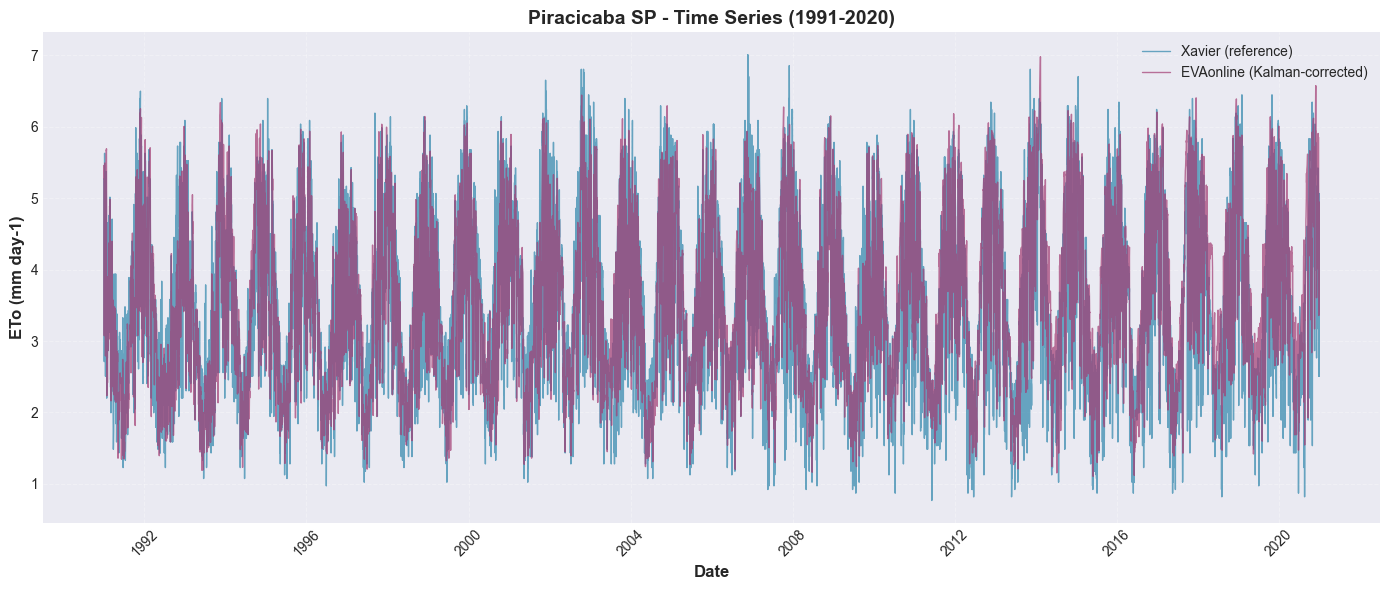


Time series plot saved: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\6_validation_full_pipeline\tutorial_output\Piracicaba_SP_timeseries.png


In [29]:
# Time series plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plot both time series
ax.plot(
    df_compare["date"],
    ref,
    label="Xavier (reference)",
    alpha=0.7,
    lw=1,
    color="#2E86AB"
)
ax.plot(
    df_compare["date"],
    calc,
    label="EVAonline (Kalman-corrected)",
    alpha=0.7,
    lw=1,
    color="#A23B72"
)

# Labels and title
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('ETo (mm day-1)', fontsize=12, fontweight='bold')
ax.set_title(f'{CITY_NAME.replace("_", " ")} - Time Series (1991-2020)', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Save plot
fig.savefig(OUTPUT_DIR / f"{CITY_NAME}_timeseries.png", dpi=300, bbox_inches='tight')
print(f"\nTime series plot saved: {OUTPUT_DIR / f'{CITY_NAME}_timeseries.png'}")

### 11.3 Residuals Analysis

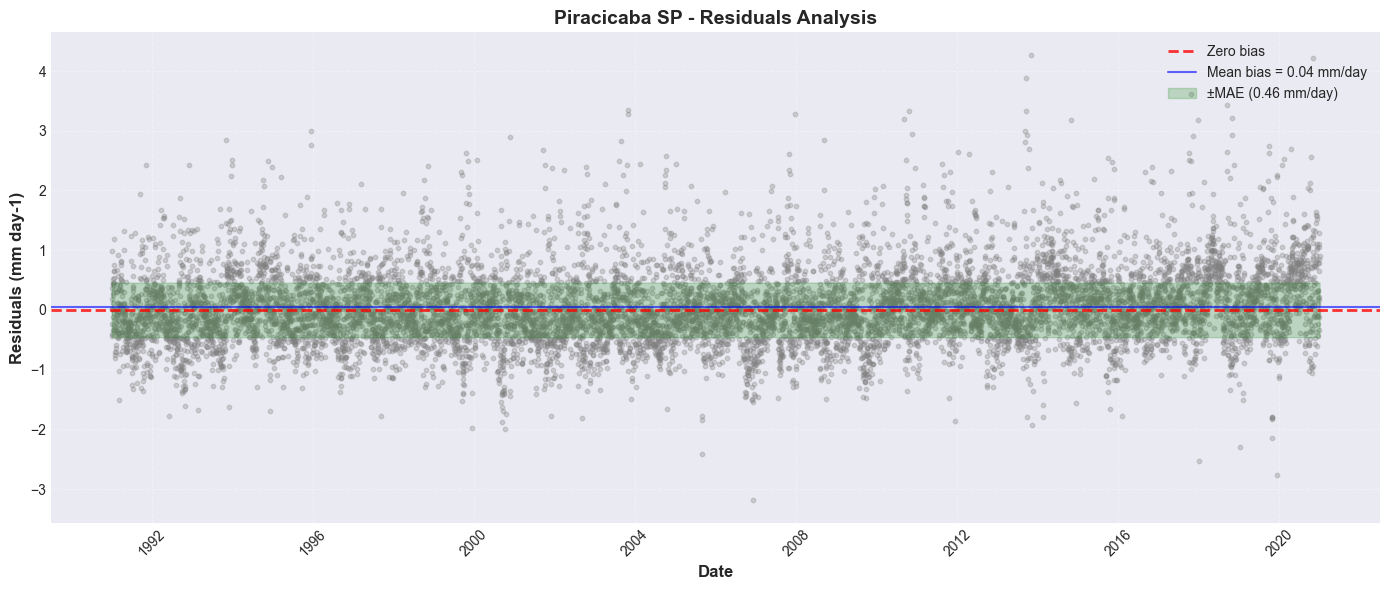


Residuals plot saved: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\6_validation_full_pipeline\tutorial_output\Piracicaba_SP_residuals.png


In [30]:
# Residuals plot
residuals = calc - ref

fig, ax = plt.subplots(figsize=(14, 6))

# Scatter residuals
ax.scatter(
    df_compare["date"],
    residuals,
    alpha=0.3,
    s=10,
    color="gray"
)

# Zero line
ax.axhline(y=0, color='r', linestyle='--', lw=2, alpha=0.8, label='Zero bias')

# Mean bias
ax.axhline(
    y=np.mean(residuals),
    color='b',
    linestyle='-',
    lw=1.5,
    alpha=0.6,
    label=f'Mean bias = {bias:.2f} mm/day'
)

# ±MAE band
ax.fill_between(
    df_compare["date"],
    -mae,
    mae,
    alpha=0.2,
    color='green',
    label=f'±MAE ({mae:.2f} mm/day)'
)

# Labels and title
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Residuals (mm day-1)', fontsize=12, fontweight='bold')
ax.set_title(f'{CITY_NAME.replace("_", " ")} - Residuals Analysis', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Save plot
fig.savefig(OUTPUT_DIR / f"{CITY_NAME}_residuals.png", dpi=300, bbox_inches='tight')
print(f"\nResiduals plot saved: {OUTPUT_DIR / f'{CITY_NAME}_residuals.png'}")

### 11.4 Error Distribution (Histogram + Normal Fit)

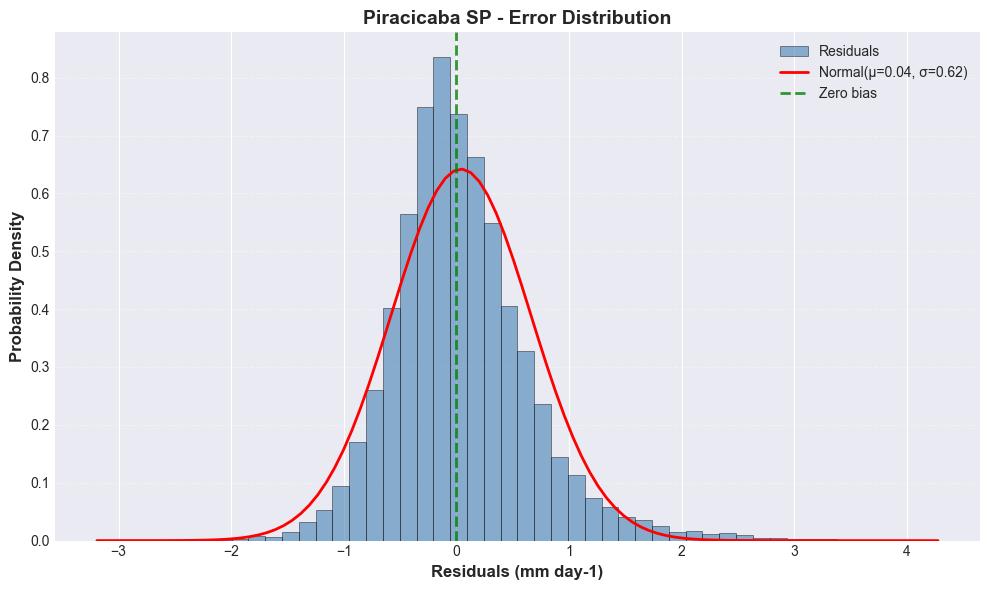


Distribution plot saved: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\6_validation_full_pipeline\tutorial_output\Piracicaba_SP_distribution.png


In [32]:
# Error distribution plot
fig, ax = plt.subplots(figsize=(10, 6))

# Histogram
ax.hist(
    residuals,
    bins=50,
    density=True,
    alpha=0.6,
    color='steelblue',
    edgecolor='black',
    linewidth=0.5,
    label='Residuals'
)

# Normal distribution fit
mu, std = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 100)
ax.plot(
    x,
    scipy_norm.pdf(x, mu, std),
    'r-',
    lw=2,
    label=f'Normal(μ={mu:.2f}, σ={std:.2f})'
)

# Zero line
ax.axvline(
    x=0,
    color='green',
    linestyle='--',
    lw=2,
    alpha=0.8,
    label='Zero bias'
)

# Labels and title
ax.set_xlabel('Residuals (mm day-1)', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability Density', fontsize=12, fontweight='bold')
ax.set_title(f'{CITY_NAME.replace("_", " ")} - Error Distribution', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--', axis='y')

plt.tight_layout()
plt.show()

# Save plot
fig.savefig(OUTPUT_DIR / f"{CITY_NAME}_distribution.png", dpi=300, bbox_inches='tight')
print(f"\nDistribution plot saved: {OUTPUT_DIR / f'{CITY_NAME}_distribution.png'}")

### 11.5 Combined Publication-Ready Figure (4 Panels)

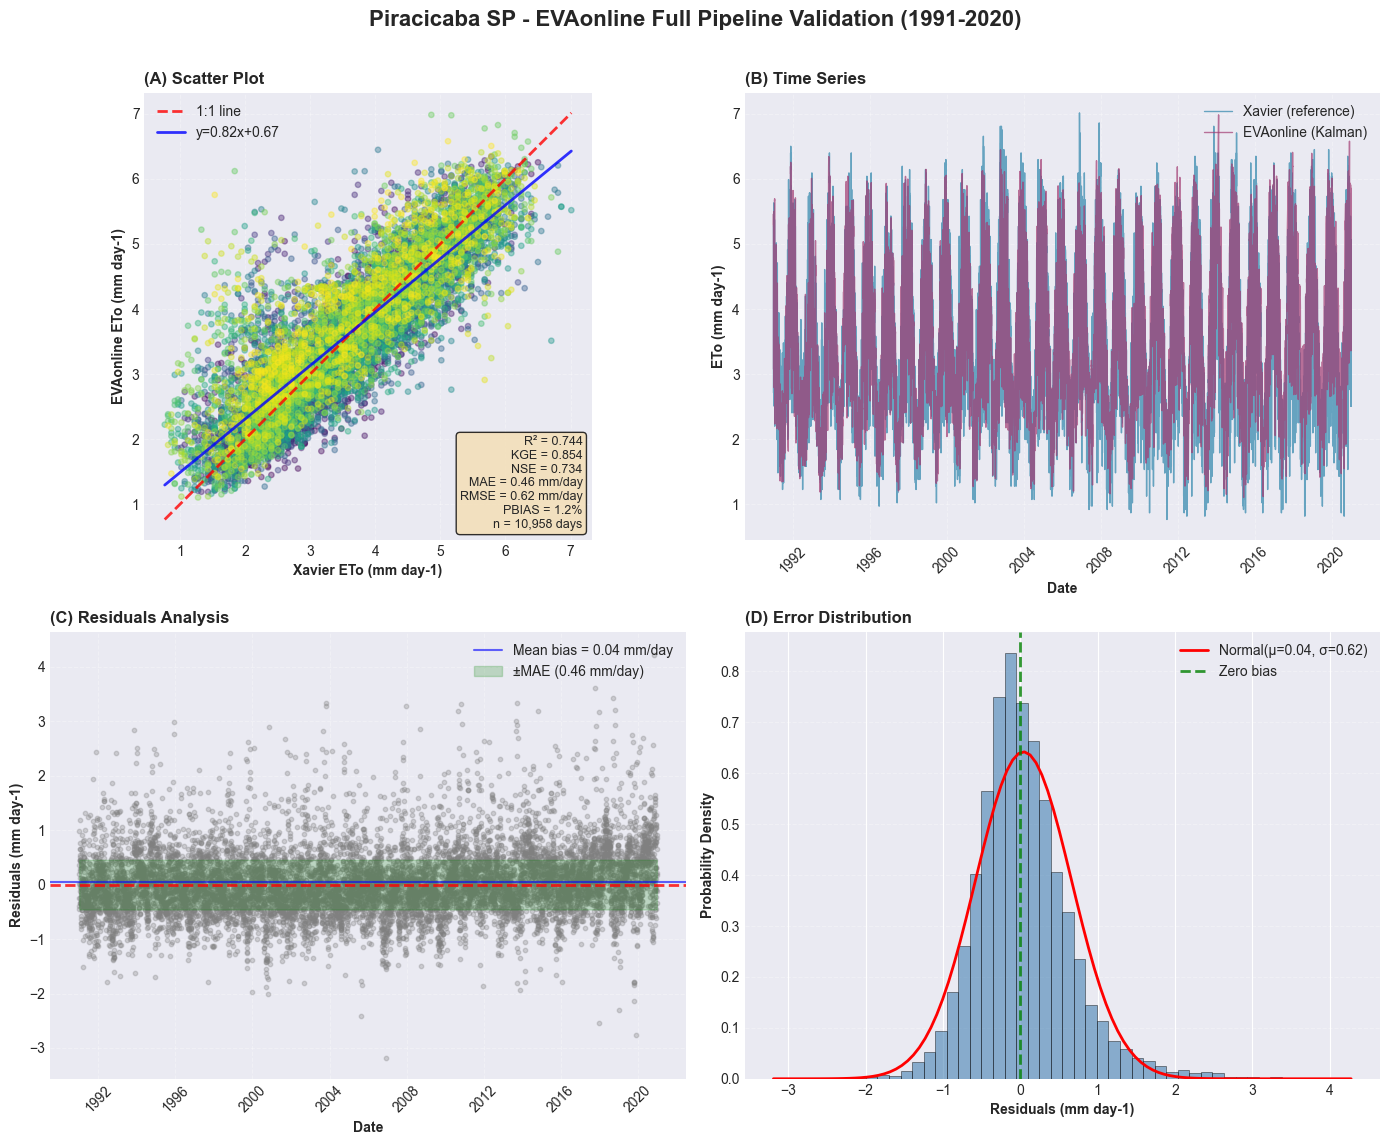


Combined figure saved:
   PNG: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\6_validation_full_pipeline\tutorial_output\Piracicaba_SP_combined.png
   PDF: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\6_validation_full_pipeline\tutorial_output\Piracicaba_SP_combined.pdf


In [33]:
# Combined 4-panel figure
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle(
    f'{CITY_NAME.replace("_", " ")} - EVAonline Full Pipeline Validation (1991-2020)',
    fontsize=16,
    fontweight='bold'
)

# (A) Scatter plot
ax1 = axes[0, 0]
ax1.scatter(ref, calc, c=np.arange(len(ref)), cmap='viridis', alpha=0.4, s=15)
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='1:1 line', alpha=0.8)
ax1.plot(
    [min_val, max_val],
    [slope_val * min_val + intercept_val, slope_val * max_val + intercept_val],
    'b-', lw=2, label=f'y={slope_val:.2f}x+{intercept_val:.2f}', alpha=0.8
)
ax1.set_xlabel('Xavier ETo (mm day-1)', fontweight='bold')
ax1.set_ylabel('EVAonline ETo (mm day-1)', fontweight='bold')
ax1.set_title('(A) Scatter Plot', fontweight='bold', loc='left')
ax1.legend(loc='upper left', framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_aspect('equal', adjustable='box')

# Add metrics
textstr = '\n'.join([
    f'R² = {r2:.3f}',
    f'KGE = {kge:.3f}',
    f'NSE = {nse:.3f}',
    f'MAE = {mae:.2f} mm/day',
    f'RMSE = {rmse:.2f} mm/day',
    f'PBIAS = {pbias:.1f}%',
    f'n = {len(ref):,} days'
])
props = {'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.8}
ax1.text(0.98, 0.02, textstr, transform=ax1.transAxes, fontsize=9,
         verticalalignment='bottom', horizontalalignment='right', bbox=props)

# (B) Time series
ax2 = axes[0, 1]
ax2.plot(df_compare["date"], ref, label="Xavier (reference)", alpha=0.7, lw=1, color='#2E86AB')
ax2.plot(df_compare["date"], calc, label="EVAonline (Kalman)", alpha=0.7, lw=1, color='#A23B72')
ax2.set_xlabel('Date', fontweight='bold')
ax2.set_ylabel('ETo (mm day-1)', fontweight='bold')
ax2.set_title('(B) Time Series', fontweight='bold', loc='left')
ax2.legend(loc='upper right', framealpha=0.9)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.tick_params(axis='x', rotation=45)

# (C) Residuals
ax3 = axes[1, 0]
ax3.scatter(df_compare["date"], residuals, alpha=0.3, s=10, color='gray')
ax3.axhline(y=0, color='r', linestyle='--', lw=2, alpha=0.8)
ax3.axhline(y=np.mean(residuals), color='b', linestyle='-', lw=1.5, alpha=0.6,
            label=f'Mean bias = {bias:.2f} mm/day')
ax3.fill_between(df_compare["date"], -mae, mae, alpha=0.2, color='green',
                 label=f'±MAE ({mae:.2f} mm/day)')
ax3.set_xlabel('Date', fontweight='bold')
ax3.set_ylabel('Residuals (mm day-1)', fontweight='bold')
ax3.set_title('(C) Residuals Analysis', fontweight='bold', loc='left')
ax3.legend(loc='upper right', framealpha=0.9)
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.tick_params(axis='x', rotation=45)

# (D) Distribution
ax4 = axes[1, 1]
ax4.hist(residuals, bins=50, density=True, alpha=0.6, color='steelblue',
         edgecolor='black', linewidth=0.5)
ax4.plot(x, scipy_norm.pdf(x, mu, std), 'r-', lw=2,
         label=f'Normal(μ={mu:.2f}, σ={std:.2f})')
ax4.axvline(x=0, color='green', linestyle='--', lw=2, alpha=0.8, label='Zero bias')
ax4.set_xlabel('Residuals (mm day-1)', fontweight='bold')
ax4.set_ylabel('Probability Density', fontweight='bold')
ax4.set_title('(D) Error Distribution', fontweight='bold', loc='left')
ax4.legend(loc='upper right', framealpha=0.9)
ax4.grid(True, alpha=0.3, linestyle='--', axis='y')

plt.tight_layout(rect=(0, 0.03, 1, 0.97))
plt.show()

# Save combined figure
fig.savefig(OUTPUT_DIR / f"{CITY_NAME}_combined.png", dpi=300, bbox_inches='tight')
fig.savefig(OUTPUT_DIR / f"{CITY_NAME}_combined.pdf", dpi=300, bbox_inches='tight')
print(f"\nCombined figure saved:")
print(f"   PNG: {OUTPUT_DIR / f'{CITY_NAME}_combined.png'}")
print(f"   PDF: {OUTPUT_DIR / f'{CITY_NAME}_combined.pdf'}")

## 12. Save Results

### 12.1 Save Processed Data

In [ ]:
# # Save comparison data
# output_csv = OUTPUT_DIR / f"{CITY_NAME}_comparison.csv"
# df_compare.to_csv(output_csv, index=False)
# print(f"\nComparison data saved: {output_csv}")

# # Save metrics summary
# metrics_summary = pd.DataFrame([{
#     'city': CITY_NAME,
#     'n_days': len(df_compare),
#     'r2': round(r2, 4),
#     'kge': round(kge, 4),
#     'nse': round(nse, 4),
#     'mae': round(mae, 4),
#     'rmse': round(rmse, 4),
#     'bias': round(bias, 4),
#     'pbias': round(pbias, 2),
#     'slope': round(slope_val, 4),
#     'intercept': round(intercept_val, 4),
#     'p_value': round(p_value, 6)
# }])

# metrics_csv = OUTPUT_DIR / f"{CITY_NAME}_metrics.csv"
# metrics_summary.to_csv(metrics_csv, index=False)
# print(f"Metrics summary saved: {metrics_csv}")

# print("\nAll results saved successfully!")

## 13. Summary and Conclusions

### Key Findings:

This notebook demonstrated the complete EVAonline pipeline for reference evapotranspiration estimation:

1. **Multi-source data integration**: Successfully fused NASA POWER and Open-Meteo data using adaptive Kalman filtering

2. **FAO-56 compliance**: Properly implemented wind speed conversion (10m → 2m) and all FAO-56 Penman-Monteith calculations

3. **Validation metrics**:
   - **R²**: Correlation coefficient squared
   - **KGE**: Kling-Gupta Efficiency (recommended for hydrology)
   - **NSE**: Nash-Sutcliffe Efficiency
   - **MAE/RMSE**: Error magnitude metrics
   - **PBIAS**: Systematic bias assessment

4. **Quality control**: Comprehensive visualization with scatter plots, time series, residuals, and error distribution

### References:

- **Allen et al. (1998)**: FAO-56 Penman-Monteith methodology
- **Xavier et al. (2022)**: Brazilian Daily Weather Gridded Data
- **Gupta et al. (2009)**: KGE metric for hydrological modeling
- **Kalman (1960)**: Optimal linear filtering theory

---

**For questions or collaboration**: angelassilviane@gmail.com  
**Repository**: https://github.com/silvianesoares/EVAONLINE  
**License**: AGPL-3.0